In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

file_path = 'data/milestone_ii_dataset.csv'

print("Libraries loaded. Ready to process.")

Libraries loaded. Ready to process.


In [ ]:
print("--- Loading Data & Creating Targets ---")

try:
    df_raw = pd.read_csv(file_path)
    print(f"File loaded: {file_path}")
except FileNotFoundError:
    print(f"Error: File {file_path} not found.")
    df_raw = pd.DataFrame() 

if not df_raw.empty:

    if 'date' in df_raw.columns:
        df_raw['date'] = pd.to_datetime(df_raw['date'])
    else:
        raise ValueError("Column 'date' not found in dataset.")

    # Sort for time-series operations
    df_raw = df_raw.sort_values(['country', 'date']).reset_index(drop=True)

    # Ensure oecd_rec is numeric
    df_raw['oecd_rec'] = pd.to_numeric(df_raw['oecd_rec'], errors='coerce').fillna(0).astype(int)

    print("Generating targets: 3-month and 6-month horizons...")
    # Target 1: Warning Signal (3 months ahead)
    df_raw['target_3m'] = df_raw.groupby('country')['oecd_rec'].shift(-3)

    # Target 2: Strategic Signal (6 months ahead)
    df_raw['target_6m'] = df_raw.groupby('country')['oecd_rec'].shift(-6)

    # Pre-recession flag
    if 'pre_recession' not in df_raw.columns:
        df_raw['pre_recession'] = 0 

    # Global 'Year' column
    df_raw['year'] = df_raw['date'].dt.year

    print(f"Data loaded: {len(df_raw)} rows across {df_raw['country'].nunique()} countries.")

--- Loading Data & Creating Targets ---
File loaded: data/milestone_ii_dataset.csv
Generating targets: 3-month and 6-month horizons...
Data loaded: 4284 rows across 7 countries.


In [ ]:
if not df_raw.empty:
    print("\n--- Preparing Tier 1 (Historical) Data ---")
    
    # 1. Feature Definition (Core History)
    core_concepts = ['10_yr_yld', '3_mo_yld', 'yield_curve', 'real_gdp', 'ind_out', 
                     'retail_vol', 'pcar_reg', 'unemployment', 'sahm', 'cpi', 
                     'oil', 'copper', 'national_share_price']
    
    tier_1_cols = []
    exclude_cols = ['date', 'country', 'target_3m', 'target_6m', 'oecd_rec', 'technical_rec', 'pre_recession', 'gdp_qoq_growth', 'year']
    
    for col in df_raw.columns:
        if col not in exclude_cols:
            # Check if column matches core concepts or has low missingness
            if any(c in col for c in core_concepts) or df_raw[col].isnull().mean() < 0.20:
                tier_1_cols.append(col)

    df_t1 = df_raw[['date', 'country', 'target_3m'] + tier_1_cols].copy()
    
    # CRITICAL FIX: Replace infinity with NaN
    df_t1.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop rows where future target is unknown
    df_t1 = df_t1.dropna(subset=['target_3m'])
    df_t1['target_3m'] = df_t1['target_3m'].astype(int)
    
    # Vectorized Imputation (Forward then Backward)
    print("Imputing Tier 1 values...")
    for col in tier_1_cols:
        df_t1[col] = df_t1.groupby('country')[col].ffill()
        df_t1[col] = df_t1.groupby('country')[col].bfill()
        
    df_t1 = df_t1.dropna() # Final cleanup
    print(f"Tier 1 Data Ready. Shape: {df_t1.shape}")

    # 3. Train/Test Split
    SPLIT_DATE = '2005-01-01'
    train_lr = df_t1[df_t1['date'] < SPLIT_DATE]
    test_lr = df_t1[df_t1['date'] >= SPLIT_DATE]
    
    print(f"\n--- Train/Test Split ({SPLIT_DATE}) ---")
    print(f"Train Set: {len(train_lr)} rows")
    print(f"Test Set:  {len(test_lr)} rows")
    
    X_train_lr = train_lr[tier_1_cols]
    y_train_lr = train_lr['target_3m']
    X_test_lr = test_lr[tier_1_cols]
    y_test_lr = test_lr['target_3m']
    
    # 4. Scaling
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_lr)
    X_test_scaled = scaler.transform(X_test_lr)
    
    # 5. Train Model
    print("Training Logistic Regression (Lasso)...")
    model_lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', 
                                  class_weight='balanced', random_state=42)
    model_lr.fit(X_train_scaled, y_train_lr)
    
    # 6. Predictions & Evaluation
    y_pred_lr = model_lr.predict(X_test_scaled)
    y_prob_lr = model_lr.predict_proba(X_test_scaled)[:, 1]
    
    print("\n--- Logistic Regression Evaluation ---")
    print(classification_report(y_test_lr, y_pred_lr, target_names=['Expansion', 'Recession']))
    
    roc_auc_lr = roc_auc_score(y_test_lr, y_prob_lr)
    print(f"ROC-AUC: {roc_auc_lr:.3f}")
    
    # Confusion Matrix
    cm_lr = confusion_matrix(y_test_lr, y_pred_lr)
    tn, fp, fn, tp = cm_lr.ravel()
    print(f"Confusion Matrix: TP={tp}, FN={fn}, FP={fp}, TN={tn}")

    # 7. Feature Importance
    coeffs = pd.DataFrame({
        'Feature': tier_1_cols,
        'Coefficient': model_lr.coef_[0],
        'Abs_Coeff': np.abs(model_lr.coef_[0])
    }).sort_values('Abs_Coeff', ascending=False)
    
    print("\n--- Top 10 Indicators (Logistic Regression) ---")
    print(coeffs.head(10))


--- Preparing Tier 1 (Historical) Data ---
Imputing Tier 1 values...
Tier 1 Data Ready. Shape: (4263, 172)

--- Train/Test Split (2005-01-01) ---
Train Set: 2940 rows
Test Set:  1323 rows
Scaling features...
Training Logistic Regression (Lasso)...

--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

   Expansion       0.69      0.94      0.80       849
   Recession       0.70      0.26      0.37       474

    accuracy                           0.69      1323
   macro avg       0.70      0.60      0.59      1323
weighted avg       0.70      0.69      0.65      1323

ROC-AUC: 0.726
Confusion Matrix: TP=121, FN=353, FP=52, TN=797

--- Top 10 Indicators (Logistic Regression) ---
                                             Feature  Coefficient  Abs_Coeff
60                                      cli_diff_1mo    -1.513062   1.513062
137  national_share_price_rolling_mean_12mo_lag_12mo     0.567396   0.567396
92                                 10_yr_


--- Preparing Tier 2 (Hybrid) Data ---
Imputing Tier 1 features only...
Data Prepared. Shape: (4263, 209)
Tier 1 Features: 119 | Tier 2 Features: 87

--- Train/Test Split (2005-01-01) ---
Train Set: 2940 rows
Test Set:  1323 rows
Calculated scale_pos_weight: 1.32
Training XGBoost Classifier...

--- XGBoost Evaluation ---
              precision    recall  f1-score   support

   Expansion       0.76      0.76      0.76       849
   Recession       0.57      0.57      0.57       474

    accuracy                           0.69      1323
   macro avg       0.67      0.66      0.66      1323
weighted avg       0.69      0.69      0.69      1323

ROC-AUC: 0.748
PR-AUC:  0.663
Confusion Matrix: TP=268, FN=206, FP=201, TN=648

--- Top 10 Drivers of Recession (XGBoost) ---
                          Feature  Importance
156                  cli_diff_6mo    0.037319
155                  cli_diff_3mo    0.033430
157                 cli_diff_12mo    0.017714
44                 copper_log_3mo    0.

<Figure size 1000x600 with 0 Axes>

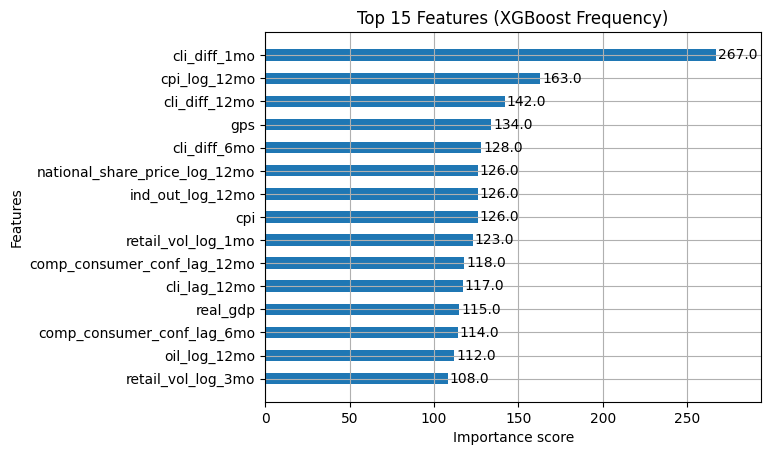

In [33]:
if not df_raw.empty:
    print("\n--- Preparing Tier 2 (Hybrid) Data ---")
    
    # 1. Feature Definition
    tier_1_concepts = ['10_yr_yld', '3_mo_yld', 'yield_curve', 'real_gdp', 'ind_out', 
                       'retail_vol', 'pcar_reg', 'unemployment', 'sahm', 'cpi', 
                       'oil', 'copper', 'national_share_price']
    
    tier_2_concepts = ['epu', 'vix', 'gps', 'cli', 'comp_consumer_conf']
    
    tier_1_cols_xgb = []
    tier_2_cols_xgb = []
    # Reuse exclude_cols from previous cell
    
    for col in df_raw.columns:
        if col in exclude_cols: continue
        
        if any(c in col for c in tier_1_concepts):
            tier_1_cols_xgb.append(col)
        elif any(c in col for c in tier_2_concepts):
            tier_2_cols_xgb.append(col)
            
    feature_cols_xgb = tier_1_cols_xgb + tier_2_cols_xgb
    
    # 2. Cleaning (Hybrid Approach)
    df_xgb = df_raw[['date', 'country', 'target_3m'] + feature_cols_xgb].copy()
    
    # Handle Infinity
    df_xgb.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop rows where target is unknown
    df_xgb = df_xgb.dropna(subset=['target_3m'])
    df_xgb['target_3m'] = df_xgb['target_3m'].astype(int)
    
    # Impute ONLY Tier 1 (Leave Tier 2 as NaN)
    print("Imputing Tier 1 features only...")
    for col in tier_1_cols_xgb:
        df_xgb[col] = df_xgb.groupby('country')[col].ffill()
        df_xgb[col] = df_xgb.groupby('country')[col].bfill()
        
    # Drop rows where Tier 1 is still missing
    df_xgb = df_xgb.dropna(subset=tier_1_cols_xgb)
    
    print(f"Data Prepared. Shape: {df_xgb.shape}")
    print(f"Tier 1 Features: {len(tier_1_cols_xgb)} | Tier 2 Features: {len(tier_2_cols_xgb)}")

    # 3. Train/Test Split
    SPLIT_DATE = '2005-01-01'
    train_xgb = df_xgb[df_xgb['date'] < SPLIT_DATE]
    test_xgb = df_xgb[df_xgb['date'] >= SPLIT_DATE]
    
    print(f"\n--- Train/Test Split ({SPLIT_DATE}) ---")
    print(f"Train Set: {len(train_xgb)} rows")
    print(f"Test Set:  {len(test_xgb)} rows")
    
    X_train_xgb = train_xgb[feature_cols_xgb]
    y_train_xgb = train_xgb['target_3m']
    X_test_xgb = test_xgb[feature_cols_xgb]
    y_test_xgb = test_xgb['target_3m']
    
    # 4. Calculate Scale Pos Weight
    neg, pos = np.bincount(y_train_xgb)
    spw = neg / pos if pos > 0 else 1
    print(f"Calculated scale_pos_weight: {spw:.2f}")
    
    # 5. Train XGBoost
    print("Training XGBoost Classifier...")
    model_xgb = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=spw,
        missing=np.nan,
        random_state=42,
        n_jobs=-1
    )
    
    model_xgb.fit(X_train_xgb, y_train_xgb)
    
    # 6. Evaluation
    y_pred_xgb = model_xgb.predict(X_test_xgb)
    y_prob_xgb = model_xgb.predict_proba(X_test_xgb)[:, 1]
    
    print("\n--- XGBoost Evaluation ---")
    print(classification_report(y_test_xgb, y_pred_xgb, target_names=['Expansion', 'Recession']))
    
    roc_auc_xgb = roc_auc_score(y_test_xgb, y_prob_xgb)
    precision, recall, _ = precision_recall_curve(y_test_xgb, y_prob_xgb)
    pr_auc_xgb = auc(recall, precision)
    print(f"ROC-AUC: {roc_auc_xgb:.3f}")
    print(f"PR-AUC:  {pr_auc_xgb:.3f}")
    # Confusion Matrix
    cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
    tn, fp, fn, tp = cm_xgb.ravel()
    print(f"Confusion Matrix: TP={tp}, FN={fn}, FP={fp}, TN={tn}")
    
    # 7. Feature Importance & Plot
    importance = pd.DataFrame({
        'Feature': feature_cols_xgb,
        'Importance': model_xgb.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n--- Top 10 Drivers of Recession (XGBoost) ---")
    print(importance.head(10))
    
    plt.figure(figsize=(10, 6))
    xgb.plot_importance(model_xgb, max_num_features=15, importance_type='weight', height=0.5)
    plt.title("Top 15 Features (XGBoost Frequency)")
    plt.show()

In [37]:
from sklearn.model_selection import TimeSeriesSplit

print("019 Pre-recession labels (these precede COVID recessions):")


mask_2019 = df_raw['year'] == 2019
df_2019 = df_raw[mask_2019]

total_2019 = len(df_2019)
if 'pre_recession' not in df_2019.columns:
    pre_rec_count = 0
else:
    pre_rec_count = df_2019['pre_recession'].sum()

pct_2019 = (pre_rec_count / total_2019) * 100 if total_2019 > 0 else 0

print(f"Total 2019 observations: {total_2019}")
print(f"Labeled as pre_recession=1: {pre_rec_count} ({pct_2019:.1f}%)")

print("By country:")
if total_2019 > 0 and 'pre_recession' in df_2019.columns:
    print(df_2019.groupby('country')['pre_recession'].agg(['sum', 'mean']))
else:
    print("No 2019 data or column missing.")

print("="*60)
print("Re-running with 2019 also excluded (pre-COVID contamination)...")
print("="*60)

df_cv = df_t1[df_t1['date'] < '2019-01-01'].copy().sort_values('date').reset_index(drop=True)

exclude_cols = ['date', 'country', 'target_3m', 'target_6m', 'year', 'oecd_rec', 'pre_recession']
valid_features = [c for c in df_cv.columns if c not in exclude_cols]

print(f"Valid features for CV: {len(valid_features)}")

X_cv = df_cv[valid_features]
y_cv = df_cv['target_3m']
dates_cv = df_cv['date']

tscv = TimeSeriesSplit(n_splits=5)

roc_scores = []
pr_scores = []

for fold_idx, (train_index, test_index) in enumerate(tscv.split(X_cv), 1):
    
    X_train_fold, X_test_fold = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train_fold, y_test_fold = y_cv.iloc[train_index], y_cv.iloc[test_index]
    dates_train_fold = dates_cv.iloc[train_index]
    dates_test_fold = dates_cv.iloc[test_index]
    
    train_end_str = dates_train_fold.max().strftime('%Y-%m')
    test_start_str = dates_test_fold.min().strftime('%Y-%m')
    test_end_str = dates_test_fold.max().strftime('%Y-%m')
    
    scaler_cv = StandardScaler()
    X_train_fold_scaled = scaler_cv.fit_transform(X_train_fold)
    X_test_fold_scaled = scaler_cv.transform(X_test_fold)
    
    model_cv = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', 
                                  class_weight='balanced', random_state=42)
    model_cv.fit(X_train_fold_scaled, y_train_fold)
    
    y_prob_fold = model_cv.predict_proba(X_test_fold_scaled)[:, 1]
    
    if len(np.unique(y_test_fold)) > 1: 
        roc_val = roc_auc_score(y_test_fold, y_prob_fold)
        precision_fold, recall_fold, _ = precision_recall_curve(y_test_fold, y_prob_fold)
        pr_val = auc(recall_fold, precision_fold)
    else:
        roc_val = 0.5
        pr_val = 0.0
    
    roc_scores.append(roc_val)
    pr_scores.append(pr_val)
    
    print(f"Fold {fold_idx}: Train to {train_end_str}, Test {test_start_str}-{test_end_str} | ROC-AUC: {roc_val:.3f} | PR-AUC: {pr_val:.3f}")

mean_roc = np.mean(roc_scores)
std_roc = np.std(roc_scores)
mean_pr = np.mean(pr_scores)
std_pr = np.std(pr_scores)

print(f"Summary (excluding 2019+):")
print(f"  Mean ROC-AUC: {mean_roc:.3f} ± {std_roc:.3f}")
print(f"  Mean PR-AUC:  {mean_pr:.3f} ± {std_pr:.3f}")

019 Pre-recession labels (these precede COVID recessions):
Total 2019 observations: 84
Labeled as pre_recession=1: 42 (50.0%)
By country:
         sum      mean
country               
Canada     8  0.666667
France     5  0.416667
Germany    0  0.000000
Italy      5  0.416667
Japan      5  0.416667
UK         8  0.666667
USA       11  0.916667
Re-running with 2019 also excluded (pre-COVID contamination)...
Valid features for CV: 136
Fold 1: Train to 1978-02, Test 1978-03-1986-04 | ROC-AUC: 0.569 | PR-AUC: 0.559
Fold 2: Train to 1986-04, Test 1986-05-1994-06 | ROC-AUC: 0.759 | PR-AUC: 0.749
Fold 3: Train to 1994-06, Test 1994-07-2002-08 | ROC-AUC: 0.640 | PR-AUC: 0.587
Fold 4: Train to 2002-08, Test 2002-09-2010-10 | ROC-AUC: 0.828 | PR-AUC: 0.673
Fold 5: Train to 2010-10, Test 2010-11-2018-12 | ROC-AUC: 0.699 | PR-AUC: 0.593
Summary (excluding 2019+):
  Mean ROC-AUC: 0.699 ± 0.090
  Mean PR-AUC:  0.632 ± 0.070
